라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'test230419-01_LSTMJaponicaTank1'

# 한글 글꼴 경로 설정
#font_path = 'C:/Windows/Fonts/malgun.ttf'  # 원하는 한글 글꼴 파일 경로로 수정해주세요
#font_name = fm.FontProperties(fname=font_path).get_name()
#plt.rc('font', family=font_name)

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test):
    X_pred = model.predict(X_test_shape)

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test)
    print("MSE // MAE // R-squared ", result)
    

In [3]:
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb

,farm_id,tank_id,feed_dt,feed_code,feed_quantity,water_quantity,add_code,add_quantity,add_code2,add_quantity2,add_code3,add_quantity3,add_code4,add_quantity4,add_code5,add_quantity5,reg_dt
0,1,1,2021-07-21 04:30:00,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
1,1,1,2021-07-21 16:30:00,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
2,1,1,2021-07-22 04:30:00,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
3,1,1,2021-07-22 16:30:00,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
4,1,1,2021-07-23 04:30:00,s2-g,6.2,9.3,c3-g,18.6,c1-g,12.4,c2-g,6.2,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,1,5,2021-09-08 16:30:00,NaN,NaN,NaN,y2-g,2200.0,y1-g,135.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
516,1,5,2021-09-09 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
517,1,5,2021-09-09 16:30:00,s2-g,1.0,1.3,c4-g,7.0,c5-g,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16 18:55:19
518,1,5,2021-09-10 04:30:00,s2-g,2.0,2.6,c4-g,14.0,c5-g,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-09-16 18:55:19


데이터셋 설정

In [4]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

#자포니카 훈련 및 검증 데이터 시계열 변환
#japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
#japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 날짜 데이터를 인덱스로 전환
#japonica_training.set_index('mea_dt', inplace=True)
#japonica_validation.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
#japonica_training = japonica_training.sort_index()
#japonica_validation = japonica_validation.sort_index()

In [5]:
japonica_training = japonica_training.fillna(0)
japonica_validation = japonica_validation.fillna(0)

In [6]:
# 자포니카 수질 훈련 데이터
japonica_training_water_quality_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_water_quality_tb.csv")

# 자포니카 수질 검증 데이터
japonica_validation_water_quality_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_water_quality_tb.csv")

# 자포니카 수질 훈련 데이터 시간 임의 추정 (식사 공급시간으로 예측)
japonica_training_water_quality_tb["measure_dt"] = japonica_training_water_quality_tb["measure_dt"].apply(str)
idx = japonica_training_water_quality_tb[japonica_training_water_quality_tb['day_type'] == 1].index
japonica_training_water_quality_tb.loc[idx, 'measure_dt'] = japonica_training_water_quality_tb.loc[idx, 'measure_dt'] + '0430'
idx = japonica_training_water_quality_tb[japonica_training_water_quality_tb['day_type'] == 2].index
japonica_training_water_quality_tb.loc[idx, 'measure_dt'] = japonica_training_water_quality_tb.loc[idx, 'measure_dt'] + '1630'

# 자포니카 수질 검증 데이터 시간 임의 추정 (식사 공급시간으로 예측)
japonica_validation_water_quality_tb["measure_dt"] = japonica_validation_water_quality_tb["measure_dt"].apply(str)
idx = japonica_validation_water_quality_tb[japonica_validation_water_quality_tb['day_type'] == 1].index
japonica_validation_water_quality_tb.loc[idx, 'measure_dt'] = japonica_validation_water_quality_tb.loc[idx, 'measure_dt'] + '0430'
idx = japonica_validation_water_quality_tb[japonica_validation_water_quality_tb['day_type'] == 2].index
japonica_validation_water_quality_tb.loc[idx, 'measure_dt'] = japonica_validation_water_quality_tb.loc[idx, 'measure_dt'] + '1630'

# 자포니카 수질 훈련 데이터 알 수 없는 값 (날짜가 7월 34일) 제거 후 날짜 타입으로 변환
japonica_training_water_quality_tb = japonica_training_water_quality_tb.drop(728)
japonica_training_water_quality_tb = japonica_training_water_quality_tb.drop(1074)
japonica_training_water_quality_tb["measure_dt"] = japonica_training_water_quality_tb["measure_dt"].astype('int64')
japonica_training_water_quality_tb['measure_dt'] = pd.to_datetime(japonica_training_water_quality_tb['measure_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_water_quality_tb["measure_dt"] = japonica_training_water_quality_tb["measure_dt"].apply(str)
japonica_training_water_quality_tb["measure_dt"] = japonica_training_water_quality_tb["measure_dt"].str.slice(start=0, stop=16)

# 자포니카 수질 검증 데이터 알 수 없는 값 (날짜가 7월 34일) 제거 후 날짜 타입으로 변환
japonica_validation_water_quality_tb = japonica_validation_water_quality_tb.drop(728)
japonica_validation_water_quality_tb = japonica_validation_water_quality_tb.drop(1074)
japonica_validation_water_quality_tb["measure_dt"] = japonica_validation_water_quality_tb["measure_dt"].astype('int64')
japonica_validation_water_quality_tb['measure_dt'] = pd.to_datetime(japonica_validation_water_quality_tb['measure_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_water_quality_tb["measure_dt"] = japonica_validation_water_quality_tb["measure_dt"].apply(str)
japonica_validation_water_quality_tb["measure_dt"] = japonica_validation_water_quality_tb["measure_dt"].str.slice(start=0, stop=16)

In [7]:
japonica_training_water_quality = pd.merge(left = japonica_training_water_quality_tb, right = japonica_training, how = "inner", left_on = ["farm_id","tank_id", "measure_dt"], right_on = ["farm_id","tank_id", "mea_dt"])
japonica_validation_water_quality = pd.merge(left = japonica_validation_water_quality_tb, right = japonica_validation, how = "inner", left_on = ["farm_id","tank_id", "measure_dt"], right_on = ["farm_id","tank_id", "mea_dt"])


In [8]:
#자포니카 수질 훈련 및 검증 데이터 시계열 변환
japonica_training_water_quality['measure_dt'] = pd.to_datetime(japonica_training_water_quality['measure_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_water_quality['measure_dt'] = pd.to_datetime(japonica_validation_water_quality['measure_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 수질 날짜 데이터를 인덱스로 전환
japonica_training_water_quality.set_index('measure_dt', inplace=True)
japonica_validation_water_quality.set_index('measure_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_water_quality = japonica_training_water_quality.sort_index()
japonica_validation_water_quality = japonica_validation_water_quality.sort_index()

In [9]:
japonica_training_water_quality.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1475 entries, 2021-07-16 04:30:00 to 2022-01-06 16:30:00
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   farm_id          1475 non-null   int64  
 1   tank_id          1475 non-null   int64  
 2   day_type         1475 non-null   int64  
 3   ammo_nitro       1470 non-null   float64
 4   a_nitric_nitro   1351 non-null   float64
 5   nitric_nitro     1461 non-null   float64
 6   alkali           1234 non-null   float64
 7   ss               1321 non-null   float64
 8   total_bacterial  1470 non-null   float64
 9   tubidity         1471 non-null   float64
 10  reg_dt_x         1475 non-null   object 
 11  Unnamed: 0       1475 non-null   int64  
 12  mea_dt           1475 non-null   object 
 13  do_mg            1475 non-null   float64
 14  do_temp          1475 non-null   float64
 15  ph               1475 non-null   float64
 16  orp              1475 no

In [10]:
# 사용할 features 선택
feature_origin = ['tank_id','a_nitric_nitro','nitric_nitro','alkali','ss','total_bacterial','tubidity','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training_water_quality[feature_origin]
japonica_validation_features = japonica_validation_water_quality[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.dropna()
japonica_validation_features = japonica_validation_features.dropna()

In [11]:
japonica_training_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1029 entries, 2021-07-16 04:30:00 to 2022-01-06 16:30:00
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tank_id          1029 non-null   int64  
 1   a_nitric_nitro   1029 non-null   float64
 2   nitric_nitro     1029 non-null   float64
 3   alkali           1029 non-null   float64
 4   ss               1029 non-null   float64
 5   total_bacterial  1029 non-null   float64
 6   tubidity         1029 non-null   float64
 7   do_mg            1029 non-null   float64
 8   do_temp          1029 non-null   float64
 9   ph               1029 non-null   float64
 10  orp              1029 non-null   float64
 11  co2_mg           1029 non-null   float64
 12  air_oxy          1029 non-null   float64
 13  light_ma         1029 non-null   float64
 14  feed_quantity    1029 non-null   float64
 15  water_quantity   1029 non-null   float64
dtypes: float64(15), int64(1)

In [15]:
from sklearn.decomposition import PCA

# PCA 모델 생성
pca = PCA(n_components=1)  # 차원을 1로 축소
pca.fit(X_scaled)  # PCA 모델 피팅

# 주성분 점수 계산하기
PC_score = pca.transform(X_scaled)

# 변수 점수 계산하기
var_score = pca.components_.T * pca.explained_variance_

# Biplots 그리기
fig, ax = plt.subplots(figsize=(100, 100))
ax.scatter(PC_score[:, 0], [0]*len(PC_score), alpha=0.5)

for i, v in enumerate(var_score):
    ax.arrow(0, 0, v[0], 0, head_width=0.1, head_length=0.1, linewidth=0.1, color='red')
    ax.text(v[0] * 1.1, 0, japonica_training_features.columns[i], color='black', ha='center', va='center')

ax.set_xlabel('PC1')
plt.show()


In [12]:
from sklearn.decomposition import PCA

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(japonica_training_features)

In [21]:
# 독립 변수, 종속 변수 분리
# 'tank_id','a_nitric_nitro','nitric_nitro','alkali','ss','total_bacterial','tubidity','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'

feature_Learning = ['a_nitric_nitro','nitric_nitro','alkali','ss','total_bacterial','tubidity','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
feature_number = len(feature_Learning)

# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_training_features_tank = japonica_training_features[japonica_training_features['tank_id']==tank]
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

japonica_training_features_X = japonica_training_features_tank[feature_Learning]
japonica_training_features_y = japonica_training_features_tank[['do_mg']]
japonica_validation_features_X = japonica_validation_features_tank[feature_Learning]
japonica_validation_features_y = japonica_validation_features_tank[['do_mg']]

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [14] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [14] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[11]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [205] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [205] unique colors! Available unique colors: [9].


[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [205] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [205] unique colors! Available unique colors: [9].


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': '11 Principal Components explain [98.75%] of the variance'}, xlabel='PC1 (23.5% expl.var)', ylabel='PC2 (14.5% expl.var)'>)

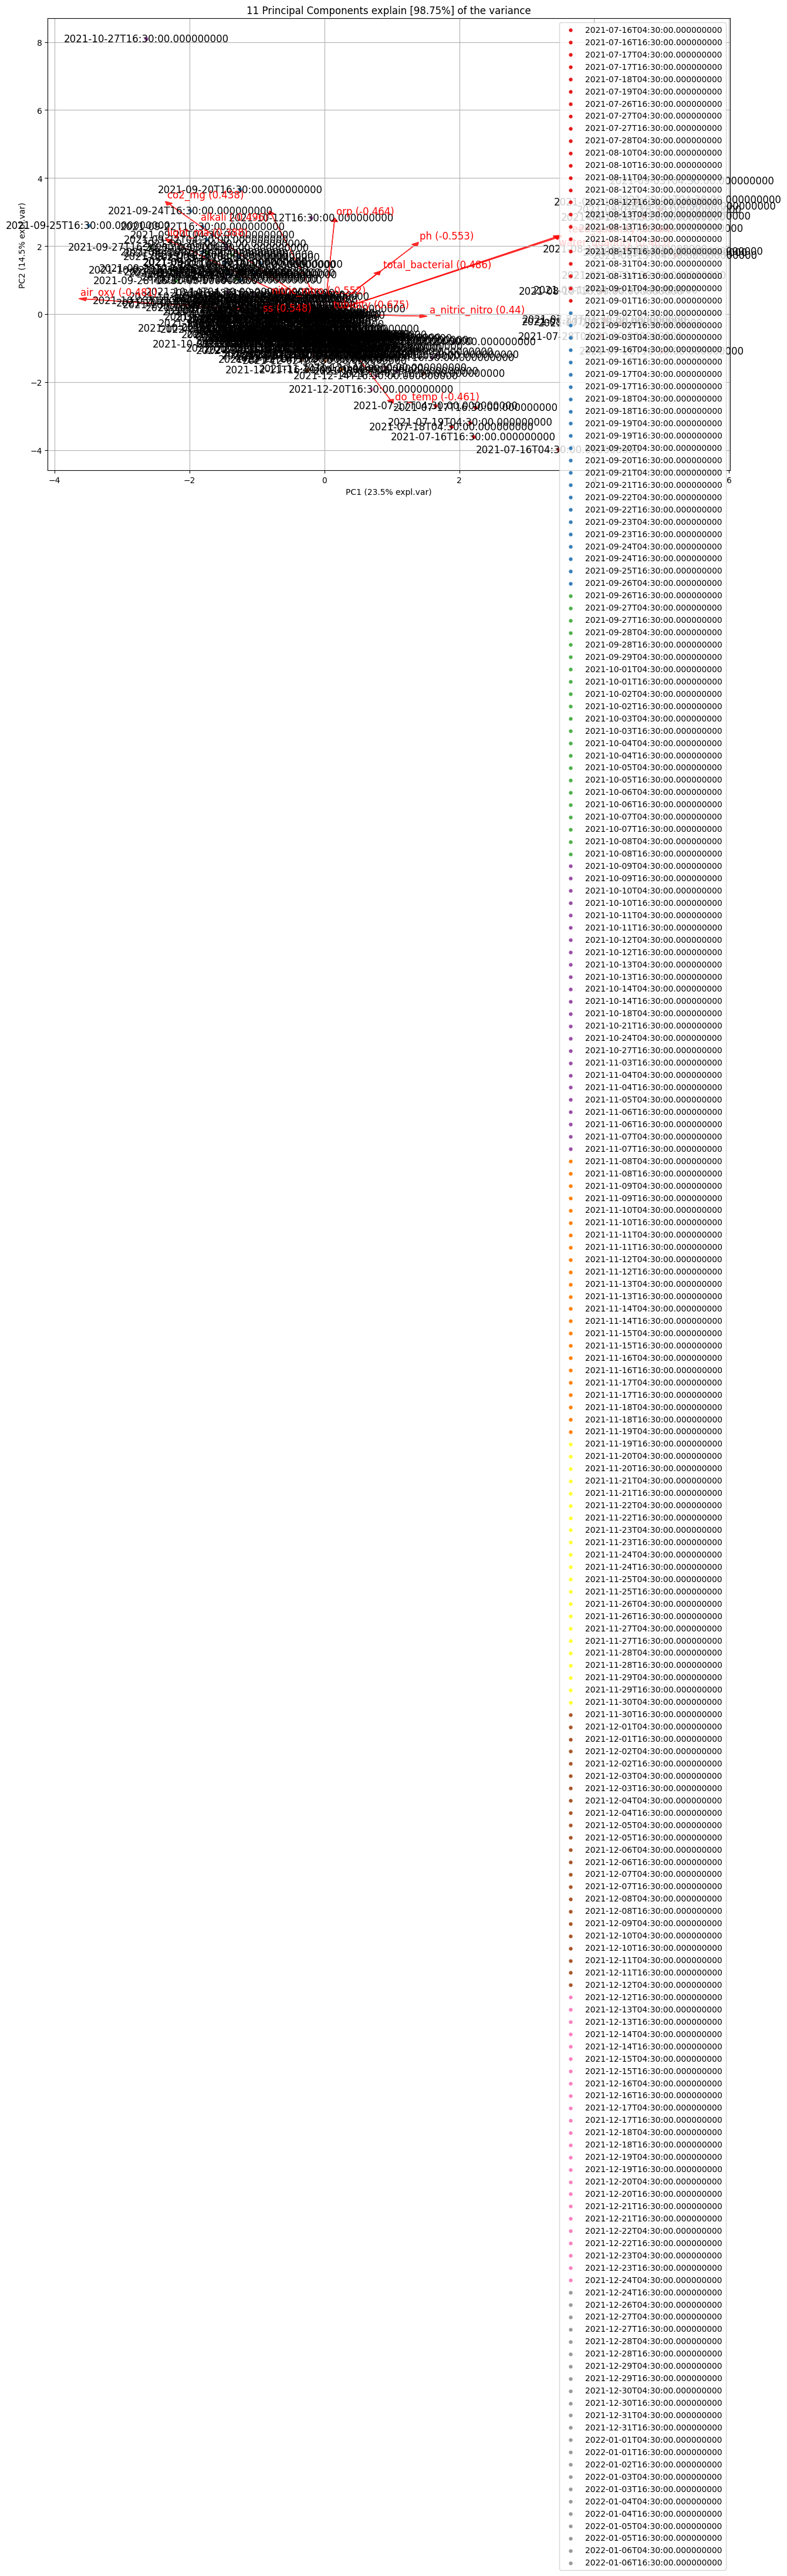

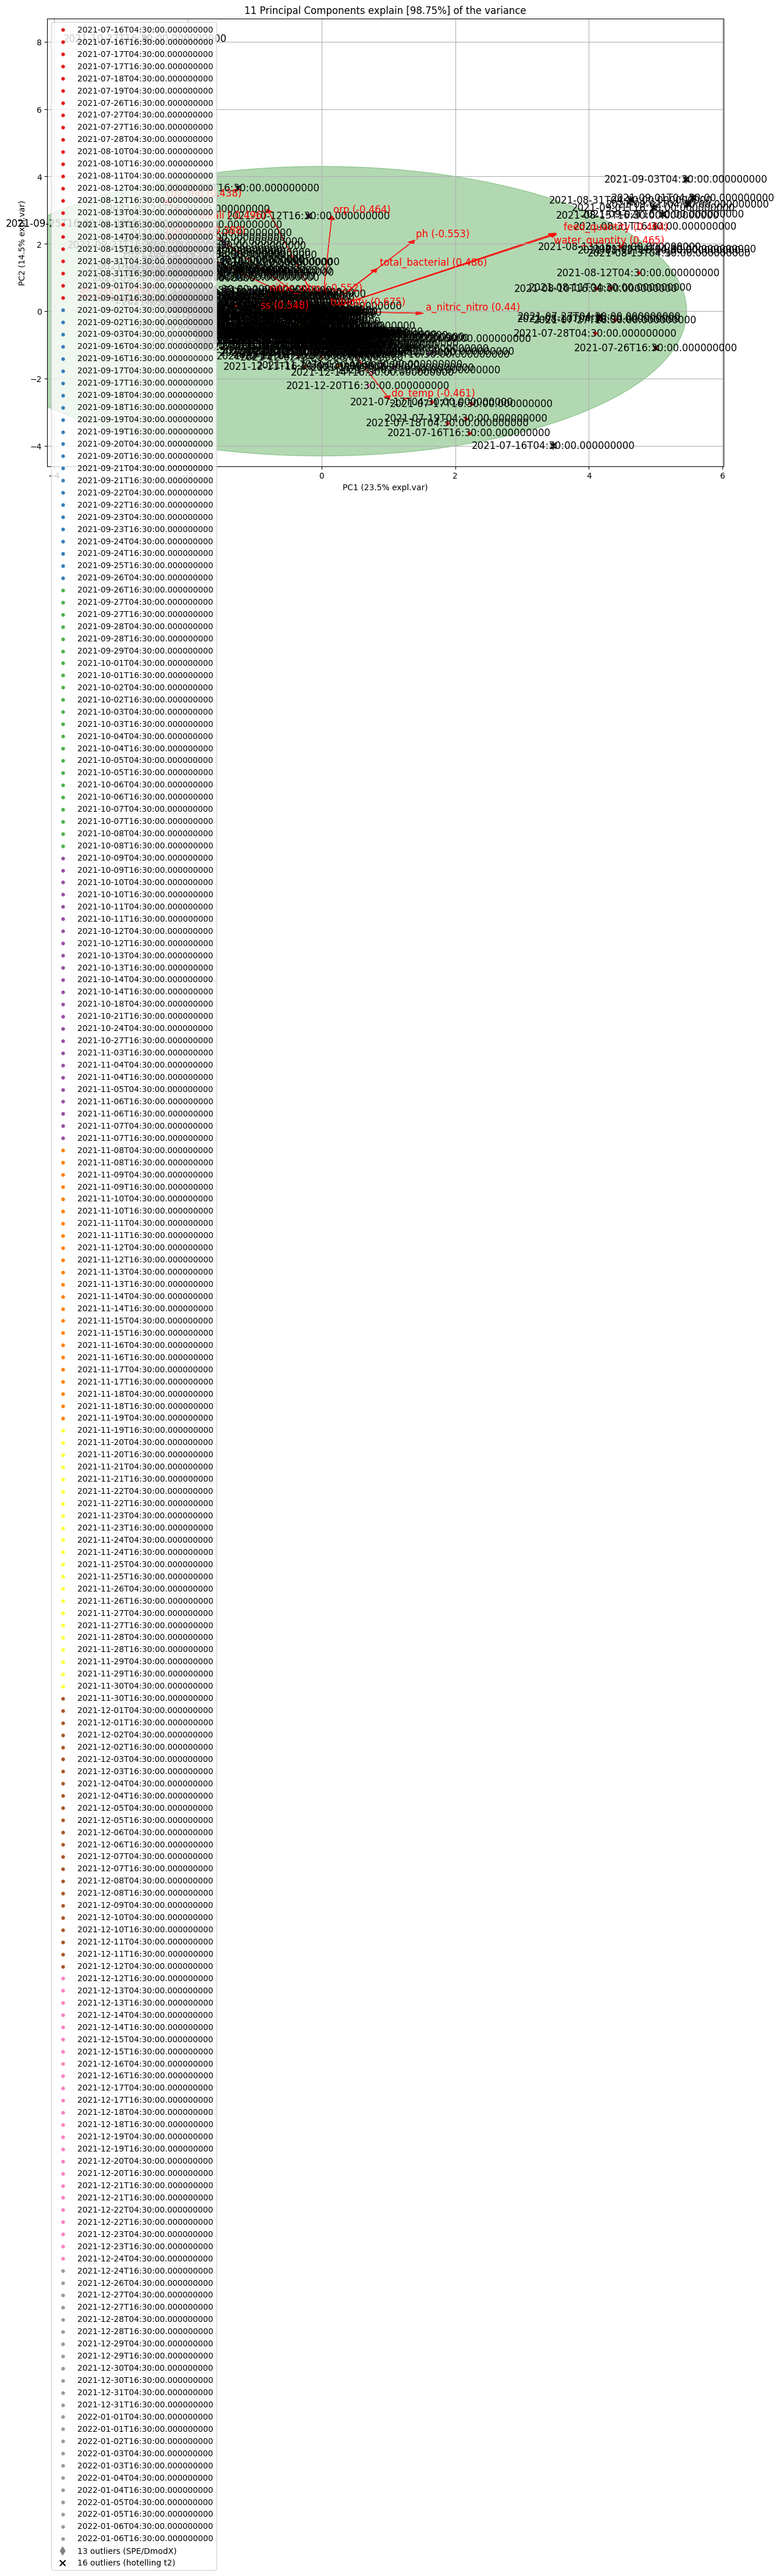

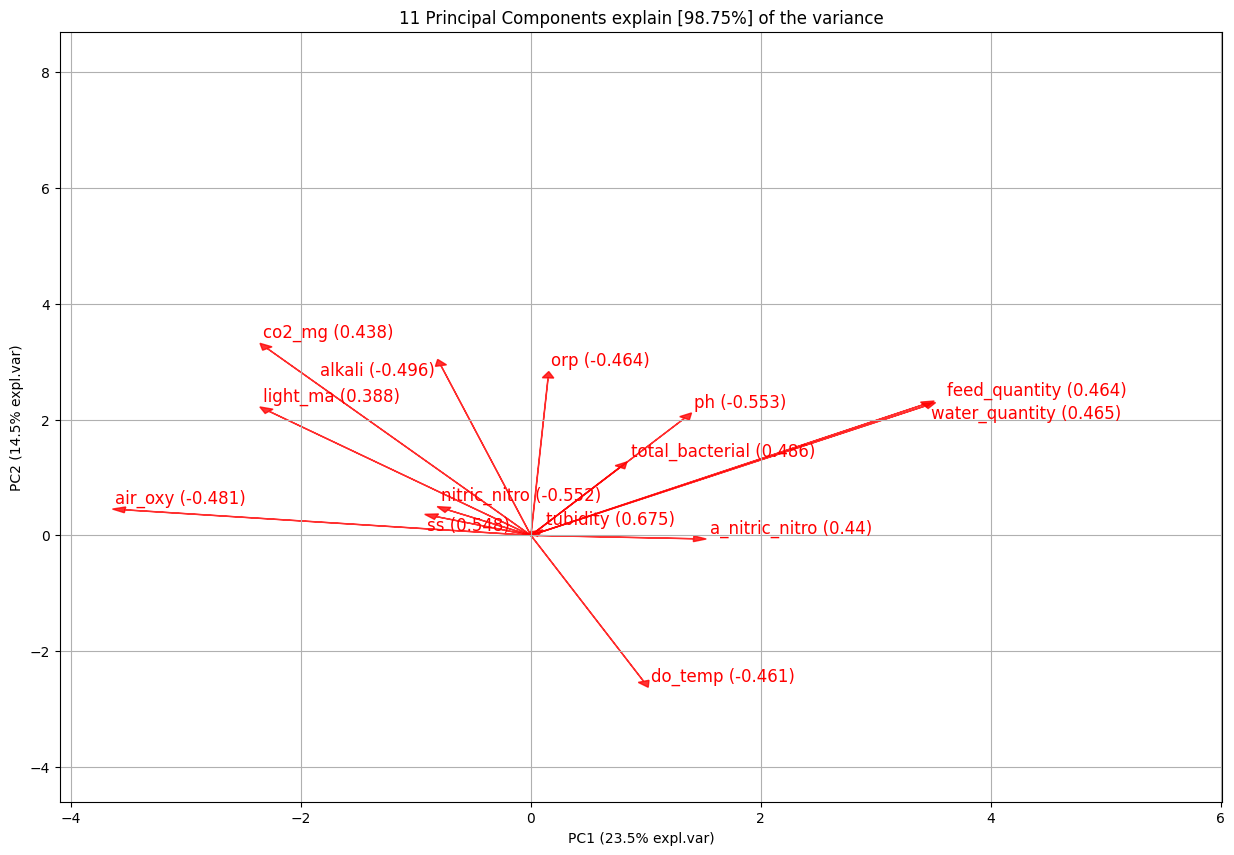

In [22]:
# Load dataset
X = japonica_training_features_X
y = japonica_training_features_y
labels = japonica_training_features_X.columns

from pca import pca
# Initialize
model = pca(normalize=True)

# Fit transform and include the column labels and row labels
results = model.fit_transform(X, col_labels=labels, row_labels=y)

# Make biplot
model.biplot()

# Here again, many other options can be turned on and off
model.biplot(SPE=True, hotellingt2=True)

model.biplot(cmap=None, label=False, legend=False)



In [ ]:
# LSTM학습을 위해 데이터 reshape를 해야함. reshape를 위해 배열형으로 변환
japonica_training_features_X_reshape = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_validation_features_X_reshape = np.asarray(japonica_validation_features_X, dtype=np.float64)

# 데이터를 3항으로 reshape. (batch_size, timesteps, features)
# batch_size: 한 번에 모델에 입력되는 샘플의 개수
# timesteps: 입력되는 시퀀스 데이터의 길이(시간축)
# features: 입력되는 데이터의 특성 개수
# 말이 어려우니까 쉽게 쓰면 (얼마 만큼의 샘플을, 시간 당 몇 개씩, 항목이 몇 개인가)
# (-1 : 있는 만큼의 샘플을, 1 : 시간당 1개씩, 8 : 피처는 8개입니다.)
japonica_training_features_X_reshape = japonica_training_features_X_reshape.reshape((-1, 1, feature_number))
japonica_validation_features_X_reshape = japonica_validation_features_X_reshape.reshape((-1, 1, feature_number))

In [ ]:
# shape확인
nCar = japonica_training_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_training_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y.shape[0] # 데이터 개수
nVar = japonica_training_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = japonica_validation_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y.shape[0] # 데이터 개수
nVar = japonica_validation_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [ ]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(1, feature_number), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.

hist = model.fit(japonica_training_features_X_reshape, japonica_training_features_y, epochs = 200, batch_size = 64, validation_data=(japonica_validation_features_X_reshape, japonica_validation_features_y), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

모델 평가

In [ ]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

In [ ]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(feature_number), weights[:, 0])
ax.set_xticks(range(feature_number))
ax.set_xticklabels(feature_Learning)
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [ ]:
grapeNEva(model, japonica_validation_features_X_reshape, japonica_validation_features_y)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-08-27 00:00:00':'2021-08-27 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)

In [ ]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-08-28 00:00:00':'2021-08-28 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

In [ ]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)